In [90]:
from matplotlib import pyplot as plt
import numpy as np
import random
import chess
import chess.svg

In [91]:
# Population size
#size_ppl = int(input("Population size:"))
size_ppl = int(100)

In [92]:
def fitnessFunction(solution):
    row_queens = 0
    col_queens = 0
    dig_queens = 0
    for row in range(solution.shape[0]):
        if (np.sum(solution[row,:]) > 1):
            row_queens += np.sum(solution[row,:]) - 1
    for col in range(solution.shape[1]):
        if (np.sum(solution[:,col]) > 1):
            col_queens += np.sum(solution[:,col]) - 1
    for i in range(-7,7):
        if (np.trace(solution, i) > 1):
            dig_queens += np.trace(solution, i) - 1
        if (np.trace(np.rot90(solution), -i) > 1):
            dig_queens += np.trace(np.rot90(solution), -i) - 1        
    return int(row_queens+col_queens+dig_queens)

In [93]:
def getRandomTuple(lst):
    p = np.random.uniform(0,1)
    if (p < 0.6):
        return random.choice(lst[0])
    if (p > 0.6) & (p < 0.9):
        return random.choice(lst[1])
    if (p > 0.9):
        return random.choice(lst[2])

In [94]:
def getRandomElement(solution, queen):
    if (queen == True):
        indxs = np.where(solution == 1)
    else:
        indxs = np.where(solution == 0)
    rows = indxs[0]
    cols = indxs[1]
    idx = random.randint(0, len(rows)-1)
    return rows[idx], cols[idx]

In [95]:
def repairBoard(solution):
    _, counts = np.unique(solution, return_counts=True)
    while (counts[1] > 8):
        row, col = getRandomElement(solution, queen=True)
        solution[row][col] = 0
        _, counts = np.unique(solution, return_counts=True)
    while (counts[1] < 8):
        row, col = getRandomElement(solution, queen=False)
        solution[row][col] = 1
        _, counts = np.unique(solution, return_counts=True)
    return solution

In [96]:
def parentSelection(population, fitness):
    fitness.sort(key=lambda a: a[1])
    split_lst = list(zip(*[iter(fitness)] * 3))
    temp = list(split_lst[2])
    temp.append(fitness[-1])
    split_lst[2] = tuple(temp)
    index_1 = getRandomTuple(split_lst)
    index_2 = getRandomTuple(split_lst)
    parent_1 = population[index_1[0]]
    parent_2 = population[index_2[0]]
    return fitness, parent_1, parent_2 

In [97]:
def generatePopulation(size):
    population = []
    apptitudes = []
    for index in range (0,size):
        solution = np.zeros(64)
        queens = random.sample(range(0, 64), 8)
        for q in queens:
            solution[q] = 1
        # 1. Solution representation with boards
        solution = solution.reshape((8,8))
        # 2. Fitness or aptitude  function with attacks
        apptitude = fitnessFunction(solution)
        apptitudes.append((index,apptitude))
        # 3. Solution population of boards
        population.append(solution)
        #print("{} <--- atacks {} \n".format(solution.astype(int), apptitude))
    return population, apptitudes

In [98]:
def crossBoard(solution1, solution2):    
    first_half1  = solution1[:,:4]
    second_half1 = solution1[:,4:]
    first_half2  = solution2[:,:4]
    second_half2 = solution2[:,4:]
    sol_1 = np.concatenate((first_half1,second_half2),axis=1)
    sol_2 = np.concatenate((first_half2,second_half1),axis=1)
    return sol_1, sol_2

In [99]:
def mutateBoard(solution):
    row_a, col_a = getRandomElement(solution, queen=True)
    row_b, col_b = getRandomElement(solution, queen=False)
    solution[row_a][col_a] = 0
    solution[row_b][col_b] = 1
    return solution

In [100]:
best_fitness = []
best_average = []
# 1. Representation, 2. Fitness and 3. Population
population, apptitudes = generatePopulation(size_ppl)
for _ in range(1000):
    # 4. Parent selection
    apptitudes, parent_1, parent_2 = parentSelection(population, apptitudes)
    # 5. Variation operators
    son_1, son_2 = crossBoard(parent_1, parent_2)
    son_1 = repairBoard(son_1)
    son_1 = mutateBoard(son_1)
    apptitude_1 = fitnessFunction(son_1)
    apptitudes.append((size_ppl,apptitude_1))
    son_2 = repairBoard(son_2)
    son_2 = mutateBoard(son_2)
    apptitude_2 = fitnessFunction(son_2)
    apptitudes.append((size_ppl+1,apptitude_2))
    #6. Board replacement mechanism
    population.append(son_1)
    population.append(son_2)
    apptitudes.sort(key=lambda a: a[1])
    population.pop(apptitudes[-1][0])
    apptitudes.pop(-1)
    if (apptitudes[-1][0] == size_ppl+1):
        population.pop(-1)
    else:
        population.pop(apptitudes[-1][0])
    apptitudes.clear()
    # Save best fitness
    average_fit = 0
    for idx in range (0,size_ppl):
        apptitude = fitnessFunction(population[idx])
        average_fit += apptitude
        apptitudes.append((idx,apptitude))
    average_fit = average_fit/size_ppl
    best_fitness.append(apptitudes[0][1])
    best_average.append(average_fit)

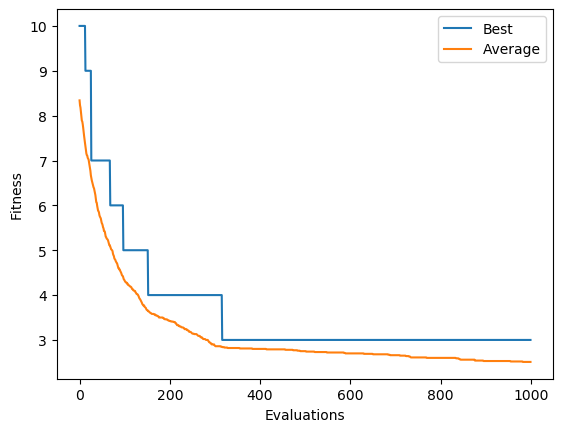

In [101]:
plt.plot(best_fitness, label='Best')
plt.plot(best_average, label='Average')

plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.legend() 
plt.show()

In [102]:
def fenCode(solution):
    fen = ''
    for i in range(8):
        count = 0
        i_row = ''
        for j in range(8):
            if (solution[i,j] == 1):
                i_row += str(count)
                i_row += 'Q'
                count = 0
            else:
                count += 1
        i_row += str(count)
        fen += '/' + i_row
    fen = fen.replace('0', '')
    return fen[1:]

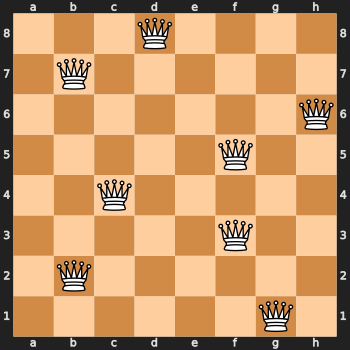

In [103]:
solution = population[0].astype(int)
fen = fenCode(solution)
board = chess.Board(fen)
boardsvg = chess.svg.board(board=board, size=350)
boardsvg